In [1]:
# Carrega os pacotes
using LinearAlgebra
using Plots
using GaussQuadrature
using DataFrames
using SparseArrays

# Formulação forte

Dadas as constantes reais $\alpha > 0$, $\beta \geq 0$ e $T > 0$, e as funções $f:[0,1]\times[0,T]\rightarrow\mathbb{R}$ e $u_0:[0,1]\rightarrow\mathbb{R}$, determine $u:[0,1]\times[0,T]\rightarrow\mathbb{R}$ tal que
\begin{align*}
\left\{
\begin{aligned}
&u_{tt}(x,t)-\alpha u_{xx}(x,t) + \beta u(x,t) = f(x,t),&& \forall (x,t)\in]0,1[\times[0,T],
\\
&u(0,t)=u(1,t)=0,                                    && \forall t\in[0,T],
\\
&u(x,0) = u_0(x),                                    && \forall x\in[0,1],
\\
&u_t(x,0) = u_1(x),                                  && \forall x\in[0,1],                 
\end{aligned}\right.
\end{align*}

Exemplos de solução exata para o problema acima:
*   Ex. 1. Se $f(x,t)=0$, então $u(x,t)=\sin(\pi x) \cos(\lambda\pi t)$, com $\lambda = \sqrt{\alpha+\beta/\pi^2}$.
*   Ex. 2. Se $f(x,t)=\sin(\pi x) \cos(\pi t)$ e $\alpha=\beta=1$, então $u(x,t)=\sin(\pi x) \cos(\pi t)$.

In [2]:
function exemplo1()
    T = 1.0
    α = 1.0
    β = 1.0
    λ = sqrt(α + β/π^2)
    f(x, t) = 0.0
    u₀(x) = sin(π * x)
    u₁(x) = 0.0
    u(x, t) = sin(π * x) * cos(λ * π * t)
    return T, α, β, f, u₀, u₁, u
end
function Exemplo2()
    T = 1.0
    α = 1.0
    β = 1.0
    f(x, t) = sin(π * x) * cos(π * t)
    u₀(x) = sin(π * x)
    u₁(x) = 0.0
    u(x, t) = sin(π * x) * cos(π * t)
    return T, α, β, f, u₀, u₁, u
end

"Retorna os valores de `T`, `α`, `β`, `f`, `u₀`, `u₁` e `u` de acordo com o exemplo escolhido."
function dados_de_entrada(exemplo::Int)
    if exemplo == 1
        return exemplo1()
    elseif exemplo == 2
        return Exemplo2()
    else
        error("Exemplo inválido. Escolha 1 ou 2.")
    end
end

dados_de_entrada

# Formulação fraca

Dadas as constantes reais $\alpha > 0$, $\beta \geq 0$ e $T > 0$, e as funções $f:[0,1]\times[0,T]\rightarrow\mathbb{R}$, $u_0:[0,1]\rightarrow\mathbb{R}$ e $u_1:[0,1]\rightarrow\mathbb{R}$, determine $u(t)\in V$, $t\in[0,T]$, tal que

\begin{align*}
\left\{
\begin{aligned}
& \int_0^1 u''(x,t)v(x) dx
+ \alpha \int_0^1\frac{\partial u}{\partial x}(x,t)\frac{\partial v}{\partial x}(x)dx
+ \beta  \int_0^1 u(x,t)v(x)dx
= \int_0^1f(x,t)v(x)dx,
\quad \forall v\in V,
\\[8pt]
& u(x,0) = u_0(x), 
\quad x\in]0,1[,
\\[8pt]
& u_t(x,0) = u_1(x), 
\quad x\in]0,1[.
\end{aligned}
\right.
\end{align*}

Para simplificar a escrita, vamos reescrever a equação acima utilizando dois operadores. O primeiro, é dado por

\begin{align*}
\kappa:V\times V\rightarrow\mathbb{R},\;(w,v)\mapsto \kappa(w,v)=
  \alpha \int_0^1\frac{d w}{d x}(x)\frac{d v}{d x}(x)dx
+ \beta  \int_0^1 w(x)v(x)dx.
\end{align*}

Quanto ao segundo operador, considere

\begin{align*}
\big(w,v\big) = \int_0^1 w(x) v(x)dx.
\end{align*}

Utilizando esses operadores, a formulação fraca pode ser reescrita como:
Dadas as constantes reais $\alpha > 0$, $\beta \geq 0$ e $T > 0$, e as funções $f:[0,1]\times[0,T]\rightarrow\mathbb{R}$, $u_0:[0,1]\rightarrow\mathbb{R}$ e $u_1:[0,1]\rightarrow\mathbb{R}$, determine $u(t)\in V$, $t\in[0,T]$, tal que

\begin{align*}
\left\{
\begin{aligned}
& \big(u''(t),v\big) + \kappa(u(t),v) = \big(f(t),v\big),
\quad \forall v\in V,
\\[8pt]
& u(0) = u_0^{},
\\[8pt]
& u'(0) = u_1^{}.
\end{aligned}
\right.
\end{align*}


## Redução de ordem da derivada temporal

Definindo $w(x,t)=u'(x,t)$, a formulação fraca definida acima pode ser reescrita como: 
Dadas as constantes reais $\alpha > 0$, $\beta \geq 0$ e $T > 0$, e as funções $f:[0,1]\times[0,T]\rightarrow\mathbb{R}$, $u_0:[0,1]\rightarrow\mathbb{R}$ e $u_1:[0,1]\rightarrow\mathbb{R}$, determine $u(t),w(t)\in V$, $t\in[0,T]$, tal que

\begin{align*}
\left\{
\begin{aligned}
& \big(w'(t),v\big) + \kappa(u(t),v) = \big(f(t),v\big),
\quad \forall v\in V,
\\[8pt]
& u'(t)=w(t), 
\\[8pt]
& u(0) = u_0^{},
\\[8pt]
& w(0) = u_1^{}.
\end{aligned}
\right.
\end{align*}

# Problema totalmente discreto - via o método de Galerkin no espaço e Crank-Nicolson no tempo

Como o título sugere, o problema aproximado será definido utilizando o método de Galerkin para a variável espacial e o método de Crank-Nicolson para a variável temporal.
No espaço, temos $V_m$, o subespaço de dimensão finita de $V$, gerado pelas funções base $\varphi_1,\varphi_2,\dots,\varphi_m$.
No tempo, precisamos estabelecer a discretização temporal para aplicar o método de diferenças finitas escolhido. 
Nesse sentido, seja $\tau>0$ uma constante real positiva, e considere $0=t_0<t_1<\dots<t_N\leq T$ uma discretização unifome no intervalo $[0,T]$.
Além disso, defina $t_{n-\frac{1}{2}}=\frac{t_n+t_{n-1}}{2}$ como o ponto médio do intervalo $[t_{n-1},t_n]$. 
A seguir, apresentamos a ilustração de uma partição do intervalo de tempo $[0,T]$.

<div style="text-align: center;">
    <img src="./imagens/Fig05.png" alt="img" style="width: 80%;">
</div>

Sob tais considerações, segue a definição do problema aproximado: Dadas as constantes reais $\alpha > 0$, $\beta \geq 0$ e $T > 0$, e as funções $f:[0,1]\times[0,T]\rightarrow\mathbb{R}$, $u_0^{},u_1^{}:[0,1]\rightarrow\mathbb{R}$ e $u_{0h}^{},u_{1h}^{}\in V_m$ aproximações para $u_0^{}$ e $u_1^{}$, respectivamente, determine $U^n,W^n\in V_m=[\varphi_1,\varphi_2,\dots,\varphi_{m}]$, tal que, para $n=1,2,\dots,N$,  

\begin{align*}
\left\{
\begin{aligned}
& \Big(\frac{W^n-W^{n-1}}{\tau},v_h\Big) + \kappa\Big(\frac{U^n+U^{n-1}}{2},v_h\Big) = \big(f(t_{n-\frac{1}{2}}),v_h\big),
\quad \forall v_h\in V_m,
\\[8pt]
& \frac{U^n-U^{n-1}}{\tau} = \frac{W^n+W^{n-1}}{2},
\\[8pt]
& U^0 = u_{0h},
\\[8pt]
& W^0 = u_{1h}.
\end{aligned}
\right.
\end{align*}

## Formulação matricial

Tomando $\displaystyle U^n(x) = \sum_{j=1}^{m} D_j^{n}\varphi_j(x)$, $\displaystyle W^n(x) = \sum_{j=1}^{m} C_j^{n}\varphi_j(x)$  e $v_h=\varphi_i$, para $i=1,2,\dots,m$, temos o seguinte sistema:
\begin{align*}
\left\{
\begin{aligned}
& M\frac{C^n-C^{n-1}}{\tau} + K\frac{D^n+D^{n-1}}{2} = F^{n-\frac{1}{2}},
\\[8pt]
& \frac{D^n-D^{n-1}}{\tau} = \frac{C^n+C^{n-1}}{2},
\\[8pt]
& D^0 = ???,
\\[8pt]
& C^0 = ???,
\end{aligned}
\right.
\end{align*}
em que, 
\begin{align*}
M_{i,j} = (\varphi_j,\varphi_i),
\quad
K_{i,j} = \kappa(\varphi_j,\varphi_i)
\quad\text{e}\quad
F_i^{n-\frac{1}{2}} = \big(f(t_{n-\frac{1}{2}}),\varphi_i\big), 
\quad\text{com}\quad
i,j\in\{1,2,3,\dots,m\}.
\end{align*}

## Isolando as incógnitas $C^n$ e $D^n$

Inicialmente, com o objetivo de eliminar a dependência da incógnita $D^n$ na primeira equação, isto é, 
$$\displaystyle 
M\frac{C^n-C^{n-1}}{\tau} + K\frac{D^n+D^{n-1}}{2} = F^{n-\frac{1}{2}},
$$
vamos expressar $D^n$ em função da incógnita $C^n$ utilizando a segunda equação, ou seja, 
$$\displaystyle 
\frac{D^n-D^{n-1}}{\tau} = \frac{C^n+C^{n-1}}{2}.
$$

Nesse sentido, isolando $D^n$ na segunda equação, temos que
$$\displaystyle
D^n = \frac{\tau}{2}(C^n+C^{n-1}) + D^{n-1}.
$$
Substituindo esta expressão na primeira equação, resulta
$$\displaystyle
M\frac{C^n-C^{n-1}}{\tau} + K\Big(\frac{\tau}{4}(C^n+C^{n-1}) + D^{n-1}\Big) = F^{n-\frac{1}{2}}.
$$
Com isso, isolando $C^n$, obtemos
$$\displaystyle
\Big(M+\frac{\tau^2}{4}K\Big)C^n = \Big(M-\frac{\tau^2}{4}K\Big)C^{n-1} - \tau K D^{n-1} + \tau F^{n-\frac{1}{2}}.
$$

Temos, assim, uma forma algorítmica de determinar as incógnitas $C^n$ e $D^n$ para cada $n\in\{1,2,\dots,N\}$.

* Passo 1: Encontre $C^n$ resolvendo o sistema linear 
$$\displaystyle
\Big(M+\frac{\tau^2}{4}K\Big)C^n = \Big(M-\frac{\tau^2}{4}K\Big)C^{n-1} - \tau K D^{n-1} + \tau F^{n-\frac{1}{2}}.
$$

* Passo 2: Determine $D^n$ a partir da expressão
$$\displaystyle
D^n = \frac{\tau}{2}(C^n+C^{n-1}) + D^{n-1}.
$$

## Aproximações para $u_0$ e $u_1$: exemplos de escolhas de $U^0,\,W^0 \in V_m$

Quaisquer funções $U^0$ e $W^0$, pertencentes ao espaço aproximado $V_m$, que sejam suficientemente próximas de $u_0$ e $u_1$, respectivamente, podem ser consideradas escolhas viáveis.
O quão próximas elas precisam estar, e em quais normas essas distâncias devem ser medidas, só se torna claro ao demonstrar a estimativa de erro entre a solução aproximada e a exata.
Não entraremos nesses detalhes aqui.
Contudo, as escolhas que apresentaremos a seguir costumam satisfazer essas condições.

A seguir, apresentaremos quatro escolhas para $U^0$. 
De forma similar, as mesmas quatro opções são aplicáveis para $W^0$. 
Portanto, para simplificar a escrita, limitaremos nossa descrição ao caso de $U^0$.

### Opção 1: Tomando $U^0$ como a interpolante de $u_0$ - se a base satisfaz a propriedade $\varphi_j(x_i) = \delta_{i,j}$

Quando a base satisfaz a propriedade $\varphi_j(x_i) = \delta_{i,j}$, onde $x_i$ é um nó da malha espacial, temos que 
$$
U^0(x_i) = \sum_{j=1}^m D_j^0 \varphi_j(x_i) = D_i^0.
$$

Consequentemente, para esse tipo de base, se tomarmos $D_i^0$ como $u_0(x_i)$, então $U^0$ interpola $u_0$.
Assim sendo, nesse caso, vamos definir
$$
D^0 =
\begin{bmatrix}
u_0(x_1)\\
u_0(x_2)\\
\vdots\\
u_0(x_m)
\end{bmatrix}.
$$

### Opção 2: Tomando $U^0$ como a projeção $L^2$ de $u_0$

Seja $U^0\in V_m$ tal que
$$
\big(U^0-u_0,v_h\big)=0,\quad\forall v_h\in V_m.
$$

Tomando $\displaystyle U^0(x) = \sum_{j=1}^{m} D_j^{0}\varphi_j(x)$ e $v_h=\varphi_i$, para $i=1,2,\dots,m$, na equação acima, temos que
$$
MD^0=
\begin{bmatrix}
\big(u_0,\varphi_1\big)\\
\big(u_0,\varphi_2\big)\\
\vdots\\
\big(u_0,\varphi_m\big)
\end{bmatrix}.
$$

### Opção 3: Tomando $U^0$ como a projeção $H_0^1$ de $u_0$

Seja $U^0\in V_m$ tal que
$$
\Big(\frac{d}{dx}(U^0-u_0),\frac{dv_h}{dx}\Big)=0,\quad\forall v_h\in V_m.
$$

Tomando $\displaystyle U^0(x) = \sum_{j=1}^{m} D_j^{0}\varphi_j(x)$ e $v_h=\varphi_i$, para $i=1,2,\dots,m$, na equação acima, temos que
$$
\begin{bmatrix}
\big(\partial_x\varphi_1,\partial_x\varphi_1\big)&\big(\partial_x\varphi_2,\partial_x\varphi_1\big)&\dots&\big(\partial_x\varphi_m,\partial_x\varphi_1\big)
\\[10pt]
\big(\partial_x\varphi_1,\partial_x\varphi_2\big)&\big(\partial_x\varphi_2,\partial_x\varphi_2\big)&\dots&\big(\partial_x\varphi_m,\partial_x\varphi_2\big)
\\
\vdots&\vdots&\ddots& \vdots  
\\
\big(\partial_x\varphi_1,\partial_x\varphi_m\big)&\big(\partial_x\varphi_2,\partial_x\varphi_m\big)&\dots&\big(\partial_x\varphi_m,\partial_x\varphi_m\big)
\end{bmatrix}
D^0=
\begin{bmatrix}
\big(\partial_xu_0,\partial_x\varphi_1\big)\\
\big(\partial_xu_0,\partial_x\varphi_2\big)\\
\vdots\\
\big(\partial_xu_0,\partial_x\varphi_m\big)
\end{bmatrix}.
$$

### Opção 4: Usando o operador $\kappa$ para realizar a projeção de $u_0$

Seja $U^0\in V_m$ tal que
$$
\kappa\big(U^0-u_0,v_h\big)=0,\quad\forall v_h\in V_m.
$$

Tomando $\displaystyle U^0(x) = \sum_{j=1}^{m} D_j^{0}\varphi_j(x)$ e $v_h=\varphi_i$, para $i=1,2,\dots,m$, na equação acima, temos que
$$
KD^0=
\begin{bmatrix}
\kappa\big(u_0,\varphi_1\big)\\
\kappa\big(u_0,\varphi_2\big)\\
\vdots\\
\kappa\big(u_0,\varphi_m\big)
\end{bmatrix}.
$$

## Monta local

### Cálculo da matriz local $K^e$ - via quadratura gaussiana

\begin{align*}
K^e_{a,b} 
 = 
  \alpha \int_{x_{1}^e}^{x_2^e}\frac{d\varphi_b^e}{dx}(x)\frac{d\varphi_a^e}{dx}(x)dx
+ \beta  \int_{x_{1}^e}^{x_2^e}\varphi_b^e(x)\varphi_a^e(x)dx
 =
\frac{2\alpha}{h} \int_{-1}^{1}
\frac{d\phi_b}{d\xi}(\xi)\frac{d\phi_a}{d\xi}(\xi)d\xi
+ \frac{\beta h}{2}  \int_{-1}^{1}
\phi_b(\xi)\phi_a(\xi) d\xi
=
\frac{2\alpha}{h} \sum_{j=1}^{n_{pg}} W_j \frac{d\phi_b}{d\xi}(P_j)\frac{d\phi_a}{d\xi}(P_j)
+ \frac{\beta h}{2} \sum_{j=1}^{n_{pg}} W_j \phi_b(P_j)\phi_a(P_j)
\end{align*}

In [3]:
"Retorna o valor de `ϕₐ(ξ)` para um dado `ξ` e `a`."
function ϕ(ξ::Float64, a::Int)::Float64
    if a == 1
        return (1.0 - ξ) / 2.0
    elseif a == 2
        return (1.0 + ξ) / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end

"Retorna a derivada de `ϕₐ(ξ)` em relação a `ξ` para um dado `ξ` e `a`."
function dϕ(ξ, a)
    if a == 1
        return -1.0 / 2.0
    elseif a == 2
        return 1.0 / 2.0
    else
        error("a deve ser 1 ou 2.")
    end
end

"Retorna a matriz local `Kᵉ` de um elemento arbitrário `e` de tamanho `h`."
function monta_Kᵉ(α::Float64, β::Float64, h::Float64)::Matrix{Float64}
    # Constantes associadas aos termos da primeira e da segunda integral
    cst1 = 2.0 * α / h
    cst2 = β * h / 2.0

    # Pontos e pesos de quadratura de Gauss-Legendre
    n_pg = 2
    P, W = legendre(n_pg)

    # Inicializa a matriz local Kᵉ
    Kᵉ = zeros(Float64, 2, 2)

    # Loop sobre as entradas da matriz local Kᵉ
    for a = 1:2
        for b = 1:2
            # Loop sobre os pontos de quadratura
            for j = 1:n_pg
                # Calcula a contribuição da quadratura na entrada Kᵉ[a,b]
                Kᵉ[a, b] += W[j] * (cst1 * dϕ(P[j], b) * dϕ(P[j], a) + cst2 * ϕ(P[j], b) * ϕ(P[j], a))
            end
        end
    end

    return Kᵉ
end

monta_Kᵉ

### Cálculo do vetor local $F^e$ - via quadratura gaussiana

\begin{align*}
F_a^e 
 = 
\int_{x_1^e}^{x_2^e}f(x)\varphi_a^e(x)dx
 =
\frac{h}{2} \int_{-1}^{1}f\big(x(\xi,e)\big)\phi_a(\xi)d\xi
 \approx
\frac{h}{2} \sum_{j=1}^{n_{pg}} W_j f\big(x(P_j,e)\big)\phi_a(P_j).
\end{align*}

In [4]:
"""
Mapeia um ponto `ξ` do intervalo padrão `[-1, 1]` para o intervalo físico `[x1e, x2e]`.

# Parâmetros
- `ξ::Float64`: Ponto no intervalo padrão `[-1, 1]`.
- `h::Float64`: Comprimento do e-ésimo elemento, calculado como `h = x2e - x1e`.
- `x1e::Float64`: Coordenada do ponto inicial `x1e` do e-ésimo elemento.

# Retorno
- Coordenada correspondente a `ξ` no intervalo `[x1e, x2e]`.
"""
function x_de_ξ(ξ::Float64, h::Float64, x1e::Float64)::Float64
    return (ξ + 1.0) * h / 2.0 + x1e
end

"""
Monta o vetor força local `Fᵉ` para o `e`-ésimo elemento `[x1e, x2e]` de tamanho `h`.

# Parâmetros
- `f::Function`: Função f(x).
- `h::Float64`: Comprimento do e-ésimo elemento, calculado como `h = x2e - x1e`.
- `x1e::Float64`: Coordenada do ponto inicial `x1e` do e-ésimo elemento.
- `P::Vector{Float64}`: Vetor dos pontos de quadratura no intervalo padrão `[-1, 1]`.
- `W::Vector{Float64}`: Vetor dos pesos de quadratura associados a `P`.

# Retorno
- `Fᵉ::Vector{Float64}`: Vetor força local de tamanho 2, correspondente ao elemento `[x1e, x2e]`.
"""
function monta_Fᵉ(f::Function, h::Float64, x1e::Float64, P::Vector{Float64}, W::Vector{Float64})::Vector{Float64}
    # Inicializa o vetor local Fᵉ
    Fᵉ = zeros(Float64, 2)

    # Loop sobre as entradas do vetor local Fᵉ
    for a = 1:2
        # Loop sobre os pontos de quadratura
        for j = 1:length(P)
            # Mapeia o ponto de quadratura `P[j]` de [-1,1] para [x1e,x2e]
            x = x_de_ξ(P[j], h, x1e)
            # Calcula e acumula a contribuição da quadratura em Fᵉ[a]
            Fᵉ[a] += W[j] * f(x) * ϕ(P[j], a) * h / 2
        end
    end

    return Fᵉ
end

monta_Fᵉ

Para calcular o vetor $F^e$, é necessário definir a função de mudança de variável que mapeia os pontos do elemento padrão $[-1, 1]$ para o e-ésimo elemento $[x_1^e, x_2^e]$.
<div style="text-align: center;">
    <img src="./imagens/Fig03.png" alt="img" style="width: 80%;">
</div>

## Estruturas auxiliares LG e EQ

### LG: Relação entre a numeração local e global das funções $\varphi$

Para adicionar corretamente os valores da matriz local $K^e$ e do vetor local $F^e$ nas devidas entradas da matriz global $K$ e do vetor global $F$, é necessário mapear a correspondência entre a numeração local e global das funções de base.
Neste momento, vamos ignorar a condição na fronteira, ou seja, quais funções globais pertencem ou não à base do subespaço de dimensão finita $V_m$. 
Vamos utilizar todas as funções globais e definir a correspondência entre a nomenclatura local e global. Essa informação será armazenada em uma matriz denotada por $LG$, as iniciais de local e global.

Dado $n_e\in\mathbb{N}$, considere a discretização uniforme do intervalo $[0,1]$, definida por $0 = x_1 < x_2 < \dots < x_{n_e} < x_{n_{e}+1} = 1$, onde cada subintervalo tem comprimento $h=1/n_e$. 
A figura abaixo ilustra a discretização da malha, assim como as funções globais $\varphi_i$, para $i=1,2,\dots,n_e+1$.

<div style="text-align: center;">
    <img src="./imagens/Fig04.png" alt="img" style="width: 80%;">
</div>



A matriz $LG$ armazena a correspondência entre a nomenclatura local e global de cada elemento finito. Assim, ela possui $n_e$ colunas, cada uma relativa a um elemento finito.
Na $e$-ésima coluna, temos a numeração global das funções locais $\varphi_1^e$ e $\varphi_2^e$.
Portanto, $LG$ tem tamanho $2\times n_e$, com cada entrada dada por

\begin{align*}
LG(a,e) = 
\begin{cases}
e,&\quad\text{se } a=1,
\\ 
e+1,&\quad\text{se } a=2.
\end{cases}
\end{align*}

A matriz $LG$ completa é dada por

\begin{align*}
LG = 
\begin{bmatrix}
1 & 2 & \dots & e-1 & e   & \dots & n_e  \\
2 & 3 & \dots & e   & e+1 & \dots & n_e+1\\
\end{bmatrix}_{2\times n_e}.
\end{align*}

In [5]:
"""
Retorna uma matriz `2 x ne` com a numeração global de cada função local.

# Parâmetros
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
"""
function monta_LG(ne::Int)::Matrix{Int}
    return transpose(hcat(1:ne, 2:ne+1))
end

monta_LG

### EQ: Relação entre a numeração global e de equação das funções $\varphi$

No caso da equação diferencial abordada, a condição na fronteira é dada por $u(0,t)=u(1,t)=0$. 
Com isso, para as funções lineares por partes que estamos considerando, a primeira e a última, ou seja, $\varphi_1$ e $\varphi_{n_e+1}$, não fazem parte da base do subespaço $V_m$. 
Portanto, essas duas funções precisam ser desconsideradas, e as demais devem ser reenumeradas. 
Essa informação será armazenada em um vetor denotado por $EQ$, as iniciais de "equação". 
Cada entrada do vetor $EQ$ possui a nova numeração de uma função global. Portanto, o tamanho do vetor $EQ$ é dado pelo número de funções globais, ou seja, $n_e + 1$.

Considerando as especificações para o tipo de fronteira e as funções $\varphi$ abordadas, o vetor $EQ$ é dado por

\begin{align*}
EQ = 
\begin{bmatrix}
m+1 & 1 & 2 &\dots & m & m+1 
\end{bmatrix}_{(n_e+1)}
\end{align*}
com $m=n_e-1$.

In [6]:
"""
Retorna o valor de `m` o vetor `EQ`.

# Parâmetros
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.

# Retorno
- Uma tupla contendo:
  - `m::Int`: A dimensão do espaço aproximado `Vₘ`. Neste problema temos que `m = ne - 1`.
  - `EQ::Vector{Int}`: Um vetor de inteiros que fornece a reenumeração das funções globais `φ`. Neste problema temos que EQ = [m + 1; 1:m; m + 1].
"""
function monta_EQ(ne::Int)::Tuple{Int,Vector{Int}}
  m = ne - 1
  EQ = vcat(m + 1, 1:m, m + 1)
  return m, EQ
end

monta_EQ

## Monta global

### Montagem da matriz global $K$ a partir da matriz local $K^e$

In [7]:
"""
Retorna a matriz tridiagonal `K` de tamanho `m x m` montada a partir da matriz local `Kᵉ`.

# Parâmetros
- `α::Float64`: Parâmetro α fornecido como dado de entrada da equação diferencial em estudo.
- `β::Float64`: Parâmetro β fornecido como dado de entrada da equação diferencial em estudo.
- `γ::Float64`: Parâmetro γ fornecido como dado de entrada da equação diferencial em estudo.
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `m::Int`: Dimensão do espaço aproximado `Vₘ`.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].
"""
function monta_K(α::Float64, β::Float64, ne::Int, m::Int, EQoLG::Matrix{Int})::SparseMatrixCSC{Float64,Int64}
    h = 1.0 / ne           # Comprimento de cada elemento finito
    K = spzeros(m + 1, m + 1)  # Inicializa a matriz esparsa K com tamanho (m+1) x (m+1)
    Kᵉ = monta_Kᵉ(α, β, h) # Calcula a matriz local Kᵉ

    # Loop sobre os elementos
    for e = 1:ne
        for a = 1:2
            i = EQoLG[a, e]
            for b = 1:2
                j = EQoLG[b, e]
                K[i, j] += Kᵉ[a, b]
            end
        end
    end

    # Remove a última linha e coluna da matriz K
    return K[1:m, 1:m]
end

monta_K

### Montagem do vetor global $F$ a partir do vetor local $F^e$

In [8]:
"""
Retorna o vetor força `F` de tamanho `m`, utilizando os vetores locais `Fᵉ`.

# Parâmetros
- `f::Function`: Função f(x).
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `m::Int`: Dimensão do espaço aproximado `Vₘ`.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].
"""
function monta_F(f::Function, ne::Int, m::Int, EQoLG::Matrix{Int})::Vector{Float64}
    h = 1.0 / ne       # Comprimento de cada elemento finito
    F = zeros(m + 1)   # Inicializa o vetor F
    P, W = legendre(5) # Pontos e pesos de quadratura de Gauss-Legendre

    # Loop sobre os elementos
    for e = 1:ne
        Fᵉ = monta_Fᵉ(f, h, (e - 1) * h, P, W) # Calcula o vetor local Fᵉ
        for a = 1:2
            i = EQoLG[a, e]
            F[i] += Fᵉ[a]
        end
    end

    # Remove a última entrada do vetor global F
    return F[1:m]
end

monta_F

# Cálculo do erro no tempo $t_n$

O erro na norma do espaço $L^2(]0,1[)$ entre a solução exata $u(x,t_n)$ e a solução aproximada $U^n(x)$, definida por $\displaystyle U^n(x) = \sum_{j=1}^m D_j^n\varphi_j(x)$, é dado por 
$\displaystyle\|u(t_n)-U^n\|=\sqrt{\int_0^1|u(x,t_n)-U^n(x)|^2dx}$.

Dessa forma, denotando $\mathcal{E}_h^n=\|u(t_n)-U^n\|$ e $\bar{D}^n=[D^n;0]$, temos que:

\begin{align*}
(\mathcal{E}_h^n)^2 
\approx
\frac{h}{2} \sum_{e=1}^{n_e} \sum_{j=1}^{n_{pg}} 
W_j|u\big(x(P_j,e),t_n\big) - \bar{D}_{EQoLG(1,e)}^n\phi_1(P_j) - \bar{D}_{EQoLG(2,e)}^n\phi_2(P_j) |^2.
\end{align*}

In [9]:
@doc raw"""
Calcula a norma L² da diferença entre duas funções, `z(x)` e `Z(x)`, 
onde `Z(x)` pertence ao espaço aproximado `Vₘ`, sendo expressa como `Z(x) = Σ_{j=1}^{m} C_j φ_j(x)`. 
A integral da diferença é aproximada em cada elemento finito por meio da quadratura de Gauss-Legendre.

# Parâmetros:
- `z::Function`: Função `z(x)` que representa a solução exata no domínio.
- `C̄::Vector{Float64}`: Vetor de coeficientes estendido, `C̄ = [C; 0]`, onde `C` é o vetor de coeficientes que define a função aproximada `Z(x)`.
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].

# Retorno:
- `Float64`: O valor do erro calculado na norma L² entre `z(x)` e a aproximação `Z(x)`.
"""
function erro_norma_L2(z::Function, C̄::Vector{Float64}, ne::Int, EQoLG::Matrix{Int})::Float64
    h = 1.0 / ne       # Comprimento de cada elemento finito
    erro = 0.0         # Inicializa o erro
    P, W = legendre(5) # Pontos e pesos da quadratura de Gauss-Legendre (5 pontos)

    # Calcula as funções de base ϕ₁ e ϕ₂ nos pontos de quadratura P
    ϕ1P = ϕ.(P, 1)
    ϕ2P = ϕ.(P, 2)

    # Loop sobre todos os elementos finitos
    for e = 1:ne
        # Coeficientes da solução aproximada para o elemento `e`
        c1e = C̄[EQoLG[1, e]]
        c2e = C̄[EQoLG[2, e]]

        # Loop sobre os pontos de quadratura
        for j = 1:length(P)
            x = x_de_ξ(P[j], h, (e - 1) * h) # Mapeia o ponto de quadratura `P[j]` de [-1,1] para [x1e,x2e]
            erro += W[j] * (z(x) - c1e * ϕ1P[j] - c2e * ϕ2P[j])^2
        end
    end

    return sqrt(erro * h / 2)
end

erro_norma_L2

# Cálculo do vetor relacionado a solução inicial: $D^0$ ou $C^0$

In [10]:
"""
Atualiza os coeficientes do vetor `vec` (`D⁰` ou `C⁰`)  in-place com base no método especificado para aproximar a função inicial `fun` (`u₀` ou `u₁`).

Existem dois métodos disponíveis:
1. **Interpolação**: Calcula `vec` por interpolação nos nós da malha (caso_solucao_inicial == 1).
2. **Projeção L²**: Calcula `vec` resolvendo um sistema linear resultante da projeção L² de `fun` (caso_solucao_inicial == 2).

# Parâmetros
- `vec::Vector{Float64}`: Vetor de coeficientes a ser modificado in-place.
- `fun::Function`: Função `fun(x)` a ser aproximada.
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `m::Int`: Dimensão do espaço aproximado `Vₘ`.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].
- `caso_solucao_inicial::Int`: Escolha do método (1 para interpolação, 2 para projeção L²).
"""
function solucao_inicial!(vec::Vector{Float64}, fun::Function, ne::Int, m::Int, EQoLG::Matrix{Int}, caso_solucao_inicial::Int)
    if caso_solucao_inicial == 1
        # Método 1: Interpolação da função `fun` nos nós da malha
        h = 1.0 / ne            # Comprimento de cada elemento finito
        @. vec = fun(h:h:1.0-h) # Atualiza o vetor `vec` com valores de `fun` nos nós
    elseif caso_solucao_inicial == 2
        # Método 2: Projeção L² da função `fun` no espaço de funções base
        vec .= monta_K(0.0, 1.0, ne, m, EQoLG) \ monta_F(fun, ne, m, EQoLG)
    else
        error("Caso inválido. Escolha 1 para interpolação ou 2 para projeção L².")
    end
end

solucao_inicial!

# Cálculo de $C^n$ e $D^n$ 

In [11]:
"""
Atualiza os coeficientes dos vetores `Cⁿ` e `Dⁿ` in-place.

# Parâmetros
- `Cⁿ::Vector{Float64}`: Vetor de coeficientes a ser modificado in-place.
- `Cⁿ⁻¹::Vector{Float64}`: Vetor de coeficientes da iteração anterior.
- `Dⁿ::Vector{Float64}`: Vetor de coeficientes a ser modificado in-place.
- `Dⁿ⁻¹::Vector{Float64}`: Vetor de coeficientes da iteração anterior.
- `A`: Em vez de passar o valor da matriz `A`, dado`M+τ²/4*K`, passe a LU desta.
- `B::SparseMatrixCSC{Float64, Int64}`: Matriz `M-τ²/4*K` do sistema linear.
- `τK::SparseMatrixCSC{Float64, Int64}`: Matriz `τ*K` do sistema linear.
- `ne::Int`: Número total de elementos (ou intervalos) em que o domínio `[0,1]` é dividido.
- `m::Int`: Dimensão do espaço aproximado `Vₘ`.
- `EQoLG::Matrix{Int}`: ≡ EQ[LG].
- `τ::Float64`: Passo de tempo.
- `n::Int`: Índice da iteração atual.
- `f::Function`: Função f(x, t).
"""
function calcula_solucao_aproximada!(Cⁿ::Vector{Float64}, Cⁿ⁻¹::Vector{Float64}, Dⁿ::Vector{Float64}, Dⁿ⁻¹::Vector{Float64}, 
    A, B::SparseMatrixCSC{Float64,Int64}, τK::SparseMatrixCSC{Float64,Int64}, 
    ne::Int, m::Int, EQoLG::Matrix{Int}, τ::Float64, n::Int, f::Function)
    # Calcula o ponto médio t_{n-\frac{1}{2}}
    t_medio = n * τ - τ / 2

    # Monta F^{n-\frac{1}{2}}
    F = monta_F(x -> f(x, t_medio), ne, m, EQoLG)

    # Atualiza Cⁿ
    Cⁿ .= A \ (B * Cⁿ⁻¹ - τK * Dⁿ⁻¹ + τ * F)

    # Atualiza Dⁿ
    @. Dⁿ = Dⁿ⁻¹ + (τ / 2) * (Cⁿ + Cⁿ⁻¹)
end

calcula_solucao_aproximada!

# Comparando a solução aproximada com a solução exata

In [12]:
function solucao_exata_vs_aproximada(exemplo, caso_solucao_inicial)
    # Carrega o exemplo escolhido
    T, α, β, f, u₀, u₁, u = dados_de_entrada(exemplo)

    # Define ne, h, τ, t e N
    ne = 4             # Número de elementos (ou intervalos) em que o domínio [0,1] é dividido
    h = 1.0 / ne       # Comprimento de cada elemento finito
    τ = h              # Passo de tempo
    t = 0:τ:T          # Vetor com a malha temporal, i.e., [0, τ, 2τ, ..., Nτ]
    N = length(t) - 1  # Número de intervalos na malha temporal

    # Define LG, m, EQ e EQoLG
    LG = monta_LG(ne)
    m, EQ = monta_EQ(ne)
    EQoLG = EQ[LG]

    # Constrói as matrizes M e K
    M = monta_K(0.0, 1.0, ne, m, EQoLG)
    K = monta_K(α, β, ne, m, EQoLG)

    # Define as matrizes A, B e τK
    A = M + (τ^2 / 4) * K
    B = M - (τ^2 / 4) * K
    τK = τ * K

    # Inicializa os vetores Cⁿ⁻¹, Cⁿ, Dⁿ⁻¹ e Dⁿ
    Cⁿ⁻¹ = zeros(m)
    Cⁿ   = zeros(m)
    Dⁿ⁻¹ = zeros(m)
    Dⁿ   = zeros(m)

    # Define as malhas de solução exata e aproximada
    malha_solucao_exata = 0:0.01:1
    malha_solucao_aproximada = 0:h:1

    # Define os limites fixos para o eixo y
    vals = [u(x,t) for x in malha_solucao_exata, t in t]
    ylim_inferior = minimum(vals) 
    ylim_superior = maximum(vals) 

    # Inicializa o vetor para armazenar os erros
    erros = zeros(N + 1)

    # Cria uma animação
    anim = @animate for n = 0:N
        # Calcula C⁰ e D⁰
        if n == 0
            solucao_inicial!(Cⁿ⁻¹, u₁, ne, m, EQoLG, caso_solucao_inicial)
            solucao_inicial!(Dⁿ⁻¹, u₀, ne, m, EQoLG, caso_solucao_inicial)
        else
            # Calcula Cⁿ e Dⁿ para n>0
            calcula_solucao_aproximada!(Cⁿ, Cⁿ⁻¹, Dⁿ, Dⁿ⁻¹, A, B, τK, ne, m, EQoLG, τ, n, f)
            Cⁿ⁻¹ .= Cⁿ
            Dⁿ⁻¹ .= Dⁿ
        end

        # Calcula o erro na norma L²
        erros[n+1] = erro_norma_L2(x -> u(x, t[n+1]), [Dⁿ⁻¹; 0], ne, EQoLG)

        # Cria a figura com layout único
        plt = plot(size=(800, 400),
            title="Soluções Exata e Aproximada em t_$(n)= $(t[n+1])",
            xlabel="x",
            legend=:topright,
            ylim=(ylim_inferior, ylim_superior))

        # Gráfico da solução exata u(x, t[n+1])
        plot!(plt, malha_solucao_exata, u.(malha_solucao_exata, t[n+1]),
            lw=3, color=:blue, label="u(x,t_$(n))")

        # Gráfico da solução aproximada Uⁿ(x)
        plot!(plt, malha_solucao_aproximada, [0; Dⁿ⁻¹; 0],
            lw=3, color=:red, linestyle=:dash, markershape=:circle, label="U^$(n)(x)")
    end

    # Exibe o erro na norma L²
    display("Erros na norma L²:")
    display(erros)

    # Exibe o erro máximo na norma L²
    display("Erro máximo na norma L²:")
    display(maximum(erros))

    # Salva o GIF
    gif(anim, "imagens/solucao_exata_vs_aproximada.gif", fps=1)
end

solucao_exata_vs_aproximada (generic function with 1 method)

"Erros na norma L²:"

5-element Vector{Float64}:
 0.0392843477687641
 0.018467683890134357
 0.03133498206789863
 0.05878107552397154
 0.0378410177850428

"Erro máximo na norma L²:"

0.05878107552397154

┌ Info: Saved animation to /home/bcarmo/git_repositories/Problema estacionario unidimensional/imagens/solucao_exata_vs_aproximada.gif
└ @ Plots /home/bcarmo/.julia/packages/Plots/kLeqV/src/animation.jl:156


Plots.AnimatedGif("/home/bcarmo/git_repositories/Problema estacionario unidimensional/imagens/solucao_exata_vs_aproximada.gif")
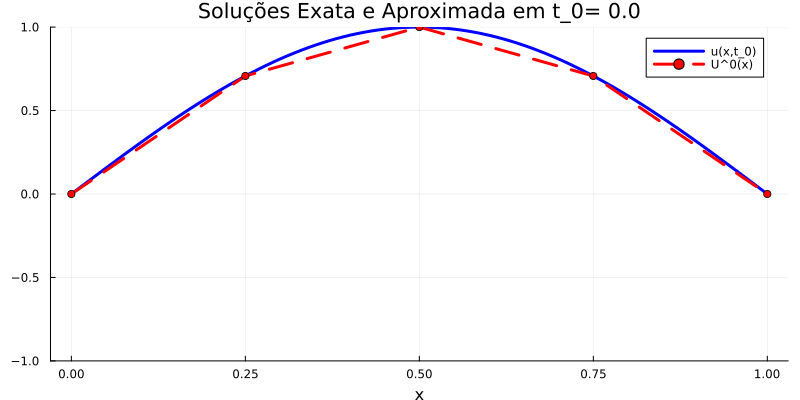

In [13]:
exemplo = 2
caso_solucao_inicial = 1
solucao_exata_vs_aproximada(exemplo, caso_solucao_inicial)

# Estudo da convergência do erro

In [14]:
function estudo_do_erro(exemplo::Int, caso_solucao_inicial::Int)
    # Carrega o exemplo escolhido
    T, α, β, f, u₀, u₁, u = dados_de_entrada(exemplo)

    # Define os valores de ne, h e τ a serem utilizados
    vec_ne = [2^i for i = 2:14]
    vec_h = 1.0 ./ vec_ne
    vec_τ = vec_h

    # Inicializa o vetor para armazenar os erros
    vec_erros = zeros(length(vec_ne))

    # Calcula o erro para cada valor de ne
    for idx = 1:length(vec_ne)
        # Define ne, h, τ, t e N
        ne = vec_ne[idx]  # Número de elementos em que o domínio [0,1] é dividido
        h = vec_h[idx]    # Comprimento de cada elemento finito
        τ = vec_τ[idx]    # Passo de tempo
        t = 0:τ:T         # Vetor de tempos tₙ
        N = length(t) - 1 # Número de intervalos na malha temporal

        # Define LG, m, EQ e EQoLG
        LG = monta_LG(ne)
        m, EQ = monta_EQ(ne)
        EQoLG = EQ[LG]

        # Constrói as matrizes M e K
        M = monta_K(0.0, 1.0, ne, m, EQoLG)
        K = monta_K(α, β, ne, m, EQoLG)

        # Define as matrizes A, B e τK
        A = M + (τ^2 / 4) * K; 
        B = M - (τ^2 / 4) * K; 
        τK = τ * K

        # Fatoração LU da matriz A (para resolver de forma eficiente A * Cⁿ = b)
        LU_A = lu(A)

        # Inicializa os vetores Cⁿ⁻¹, Cⁿ, Dⁿ⁻¹ e Dⁿ
        Cⁿ⁻¹ = zeros(m); Cⁿ = zeros(m); Dⁿ⁻¹ = zeros(m); Dⁿ = zeros(m)

        # Inicializa o vetor para armazenar os erros
        erros = zeros(N + 1)

        # Calcula C⁰, D⁰ e o erro na norma L²
        solucao_inicial!(Cⁿ⁻¹, u₁, ne, m, EQoLG, caso_solucao_inicial)
        solucao_inicial!(Dⁿ⁻¹, u₀, ne, m, EQoLG, caso_solucao_inicial)
        erros[1] = erro_norma_L2(u₀, [Dⁿ⁻¹; 0], ne, EQoLG)

        # Itera sobre os passos de tempo e calcula Cⁿ, Dⁿ e o erro
        for n = 1:N
            # Calcula Cⁿ e Dⁿ para n>0
            calcula_solucao_aproximada!(Cⁿ, Cⁿ⁻¹, Dⁿ, Dⁿ⁻¹, LU_A, B, τK, ne, m, EQoLG, τ, n, f)
            Cⁿ⁻¹ .= Cⁿ
            Dⁿ⁻¹ .= Dⁿ
            erros[n+1] = erro_norma_L2(x -> u(x, t[n+1]), [Dⁿ⁻¹; 0], ne, EQoLG)
        end

        # Armazena o máximo do erro na norma L² obtido em cada iteração
        vec_erros[idx] = maximum(erros)
    end

    return vec_h, vec_erros
end

function display_erros(vec_h, vec_erros, exemplo, caso_solucao_inicial)
    # Cria o gráfico do erro em função de h em escala logarítmica
    plt = plot(
        vec_h, vec_erros, lw=3, linestyle=:solid, markershape=:circle,
        label="Erro", title="Estudo do erro - exemplo $exemplo - caso_solucao_inicial = $caso_solucao_inicial",
        xscale=:log10, yscale=:log10, legend=:topleft
    )

    # Adiciona a curva teórica de h² ao gráfico
    plot!(plt, vec_h, vec_h.^ 2, lw=3, linestyle=:solid, label="h²")

    # Adiciona rótulos aos eixos
    xlabel!("h")
    ylabel!("Erro")

    # Exibe o gráfico
    display(plt)

    # Exibe a tabela com os valores de h e erro
    display("Tabela com os valores de h e erro - exemplo " * string(exemplo) * " - caso_solucao_inicial = " * string(caso_solucao_inicial))
    display(DataFrame(h=vec_h, erro=vec_erros))
end

display_erros (generic function with 1 method)

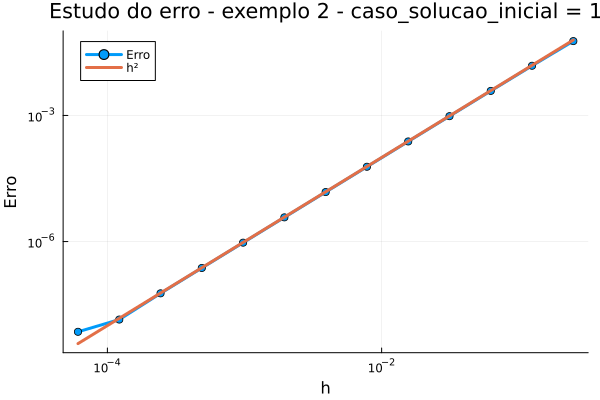

"Tabela com os valores de h e erro - exemplo 2 - caso_solucao_inicial = 1"

Row,h,erro
,Float64,Float64
1,0.25,0.0587811
2,0.125,0.0152185
3,0.0625,0.00383771
4,0.03125,0.000961498
5,0.015625,0.000240544
6,0.0078125,6.01668e-5
7,0.00390625,1.50422e-5
8,0.00195312,3.76058e-6
9,0.000976562,9.40135e-7


111.879365 seconds (1.08 G allocations: 64.134 GiB, 5.36% gc time, 0.07% compilation time)


In [15]:
exemplo = 2
caso_solucao_inicial = 1
@time begin
     vec_h, vec_erros = estudo_do_erro(exemplo, caso_solucao_inicial)
end

display_erros(vec_h, vec_erros, exemplo, caso_solucao_inicial)

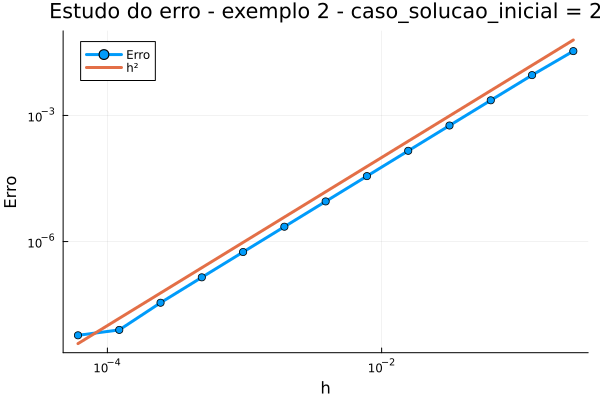

"Tabela com os valores de h e erro - exemplo 2 - caso_solucao_inicial = 2"

Row,h,erro
,Float64,Float64
1,0.25,0.0339665
2,0.125,0.00911468
3,0.0625,0.00229412
4,0.03125,0.000575955
5,0.015625,0.00014411
6,0.0078125,3.60374e-5
7,0.00390625,9.00973e-6
8,0.00195312,2.25249e-6
9,0.000976562,5.63108e-7


127.510532 seconds (1.08 G allocations: 64.173 GiB, 5.89% gc time, 0.10% compilation time)


In [16]:
exemplo = 2
caso_solucao_inicial = 2
@time begin
     vec_h, vec_erros = estudo_do_erro(exemplo, caso_solucao_inicial)
end

display_erros(vec_h, vec_erros, exemplo, caso_solucao_inicial)